# Notebook init

In [1]:
from os import getcwd, pardir
from os.path import join, abspath

# ! pip install jupyter_nbextensions_configurator jupyter_contrib_nbextensions
# ! jupyter contrib nbextension install
# ! jupyter nbextension install --py fileupload 
# ! jupyter nbextension enable --py fileupload
# ! jupyter nbextension install --py widgetsnbextension 
# ! jupyter nbextension enable --py widgetsnbextension
# ! jupyter nbextensions_configurator enable
# ! jupyter nbextension enable codefolding/main
# ! jupyter nbextension enable toc2/main

! jupyter nbextension enable --py --sys-prefix widgetsnbextension
# init_notebook_mode(connected=True)

## Get Root Directory
rootDirectory = abspath(join(abspath(join(getcwd(), pardir)), pardir))

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')

## Create a button that hides cells
from IPython.display import HTML

HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
            $('div.input').show();
        } else {
            $('div.input').hide();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Data Load

## Normal load

In [ ]:
from test_utils import *

testsDir = join(rootDirectory, 'smartcitizen-iscape-tests')

def loadButton(b):
    frequency = frequency_text.value + frequency_drop.value
    readings_selected = loadTest(frequency)
    
    for key in readings_selected.keys():
        try:
            readings[key] = dict()
            readings[key] = readings_selected[key]
        except NameError:
            global readings
            readings = dict()
            readings[key] = readings_selected[key]
    

def clearButton(b):
    
    global readings
    clearTests()
    readings = {}

display(widgets.HTML('<hr><h4>Import Local Tests</h4>'))

tests = getTests(testsDir)
interact(selectTests,
         x = widgets.SelectMultiple(options=tests, 
                           selected_labels = selectedTests, 
                           layout=widgets.Layout(width='700px')))

loadB = widgets.Button(description='Load Local Tests')
loadB.on_click(loadButton)

frequency_text = widgets.Text(description = 'Frequency',
                              value = '1',
                              layout = widgets.Layout(width='300px'))
frequency_drop = widgets.Dropdown(options = ['H', 'Min', 'S'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='100px'))

frequency_box = widgets.HBox([frequency_text, frequency_drop])

resetB = widgets.Button(description='Clear Tests')
resetB.on_click(clearButton)

buttonBox = widgets.HBox([loadB, resetB])
totalBox = widgets.VBox([frequency_box, buttonBox])
display(totalBox)

## Manual load

In [12]:
from os.path import join
import os
import pandas as pd

folder = '/Users/macoscar/Documents/04_Projects/02_FabLab/02_SmartCitizen/04_iScape/04_Deployments/KITS/03_SECOND_BATCH/'

name_reading = 'DISPERSION'
readings = dict()
readings[name_reading] = dict()
readings[name_reading]['devices'] = dict()


for root, dirs, files in os.walk(folder):
    print 'Loading files in', folder
    for _file in files:
        if _file.endswith(".CSV") or _file.endswith(".csv"):
            print _file
            name = _file[:_file.find('.')]
            dataframe = pd.read_csv(join(folder, _file), skiprows=range(1,4)).set_index('Time')
            dataframe.index = pd.to_datetime(dataframe.index).tz_localize('UTC').tz_convert('Europe/Madrid')
            dataframe.index.rename('Time', inplace = True)
            dataframe.index.strftime('%Y-%m-%dT%H%M%SZ')
            dataframe.sort_index(inplace=True)
            
            # Remove duplicates from index
            dataframe = dataframe[~dataframe.index.duplicated(keep='first')]
            
            dataframe = dataframe.apply(pd.to_numeric,errors='coerce')     
            dataframe.fillna(0)
            
            readings[name_reading]['devices'][name] = dict()
            readings[name_reading]['devices'][name]['data'] = dataframe

Loading files in /Users/macoscar/Documents/04_Projects/02_FabLab/02_SmartCitizen/04_iScape/04_Deployments/KITS/03_SECOND_BATCH/
5409.csv
5410.csv
5411.csv
5412.csv
5413.csv
5414.csv
5416.csv
5417.csv
5418.csv
5419.csv
5420.csv
5421.csv
5422.csv
5423.csv
5424.csv
5425.csv
5426.csv
5427.csv
5429.csv
5430.csv


# Load metrics

## Calculate them

In [9]:
from os import getcwd, walk
from os.path import join
import pandas as pd

devices = dict()
for root, dirs, files in walk(folder):
    for _file in files:
        if _file.endswith(".csv"):
            ocur = _file.find('.')
            readings_name = _file[:ocur]
            readings[name_reading]['devices'][readings_name] = dict()
            
            # Create pandas dataframe
            df = pd.read_csv(join(folder,_file), verbose=False).set_index('Unnamed: 0')

            df.index.rename('Time', inplace = True)
            df.index = pd.to_datetime(df.index).tz_localize('UTC')
        
            df.sort_index(inplace=True)
            df = df.apply(pd.to_numeric,errors='coerce')            
            df.fillna(0)
            max_date = df.index[-1]            
            readings[name_reading]['devices'][readings_name]['data'] = df
            
list_channels = list()

# Get list of devices
list_devices = list(readings[dispersion_test]['devices'].keys())
# Init list of common channels
list_channels = readings[dispersion_test]['devices'][list_devices[0]]['data'].columns

# Extract list of common channels
for device in readings[dispersion_test]['devices']:
    list_channels = list(set(list_channels) & set(readings[dispersion_test]['devices'][device]['data'].columns))

print(list_channels)         
            
dispersion_df = pd.DataFrame()

for channel in list_channels:
    list_columns = list()
    fig, (ax1, ax2) = plot.subplots(nrows = 2, figsize= (15,10))
    for device in list_devices:
        
        dispersion_df[channel + '-' + device] = readings[dispersion_test]['devices'][device]['data'].loc[:,channel].astype('float64')
        list_columns.append(channel + '-' + device)

    # Calculate Metrics
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
    dispersion_global = dispersion_df[channel + '_STD'].mean()
    print channel, dispersion_global

KeyError: 'Unnamed: 0'

## Load from history

In [13]:
## Channel, dev, sigma
dispersion_history = (['NOISE_A', 2.33323416585, 5],
                      ['TEMP', 0.402864267636, 5],
                      ['HUM', 1.49624685732, 5],
                      ['PM_1', 1.35653211631, 2],
                      ['PM_10', 2.3327409954, 2],
                      ['PM_25', 1.94100236525, 2],
                      ['PRESS', 0.0490177780217, 3])

# Extract faulty devices

Min - Max Date
2018-12-20 10:17:00+01:00 2018-12-20 21:06:00+01:00
['NOISE_A', 'TEMP', 'HUM', 'PM_1', 'PM_10', 'PM_25', 'PRESS']


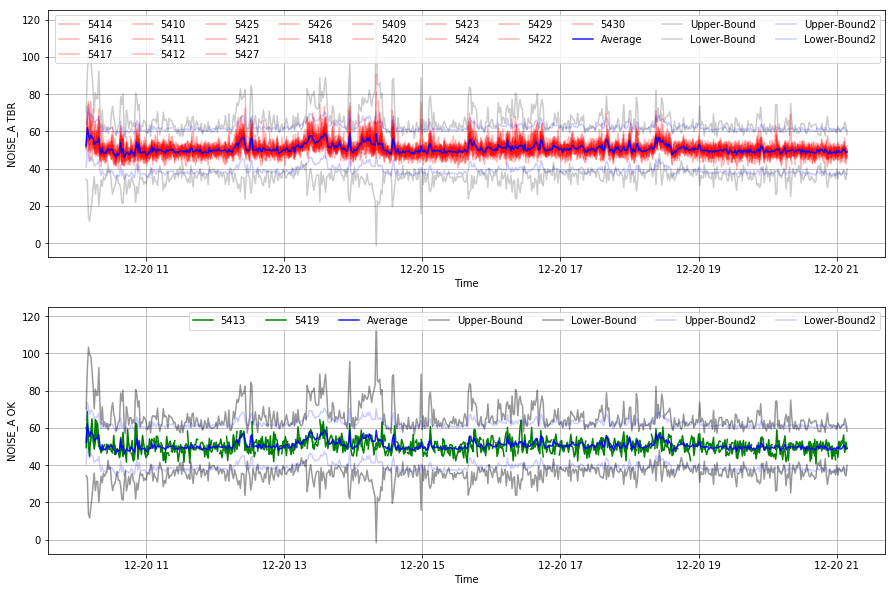

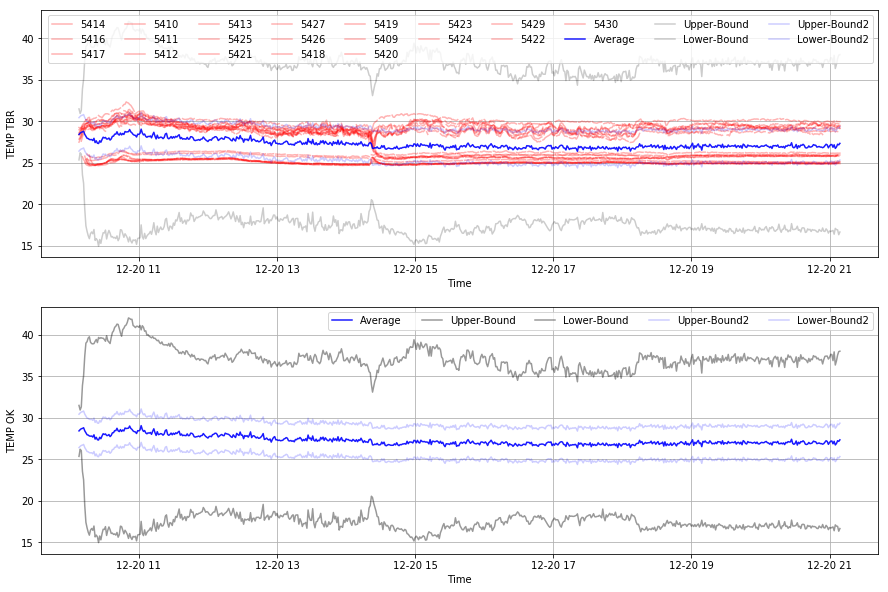

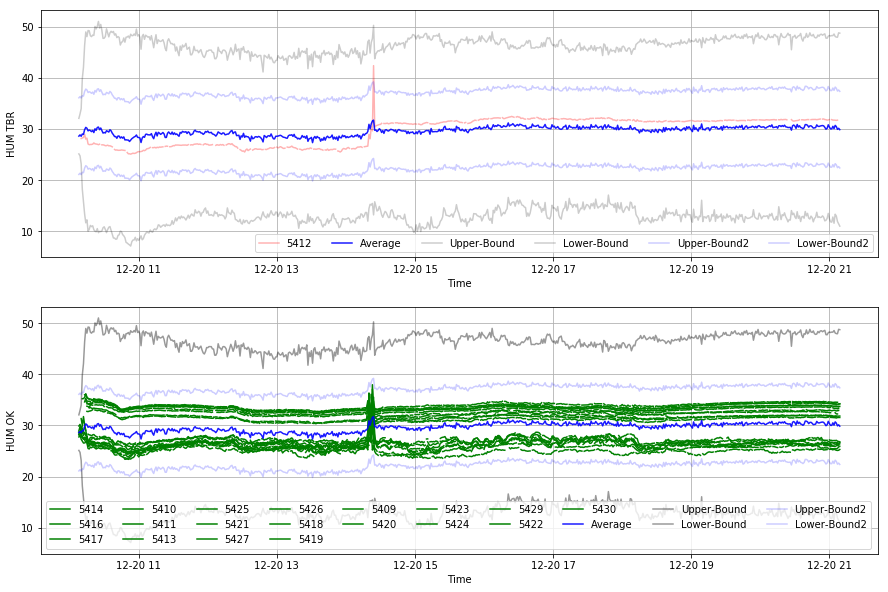

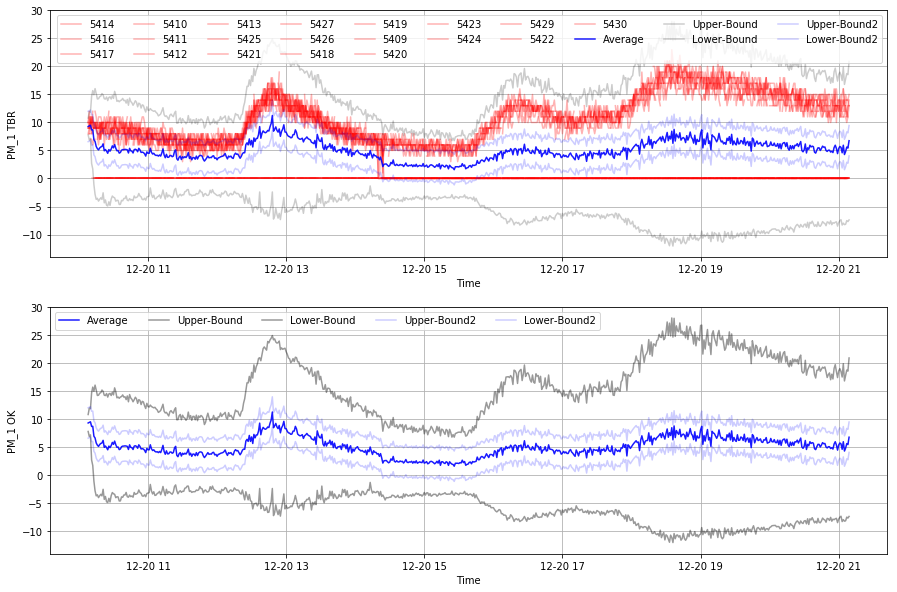

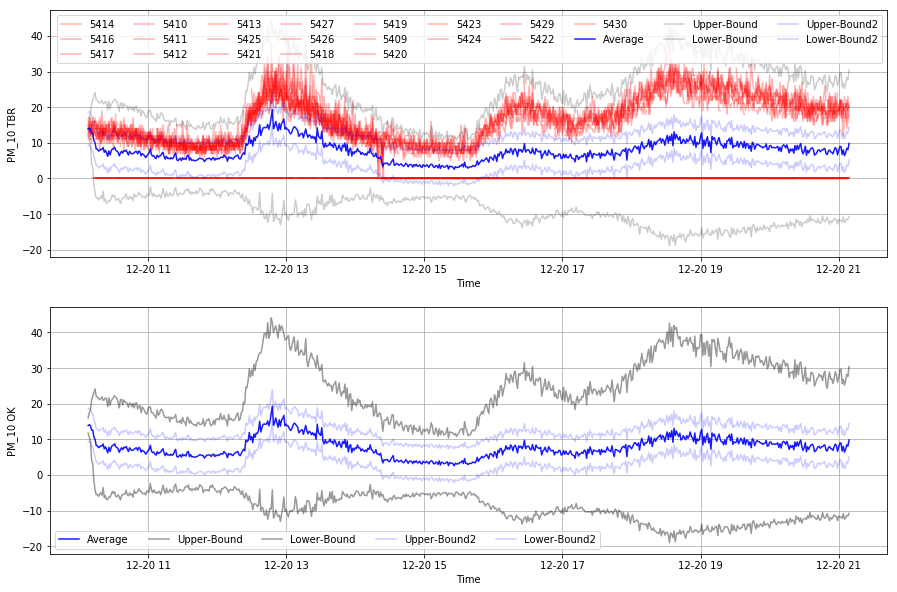

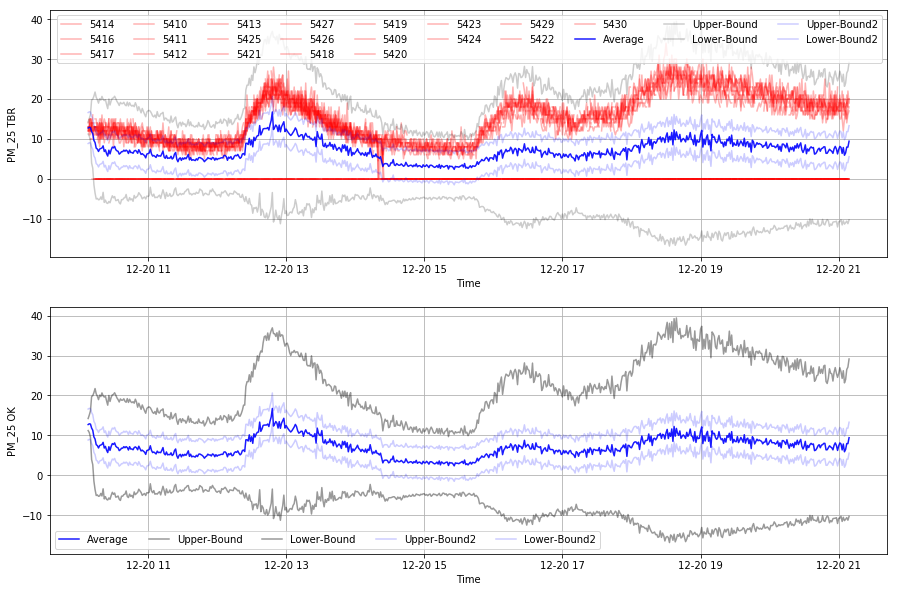

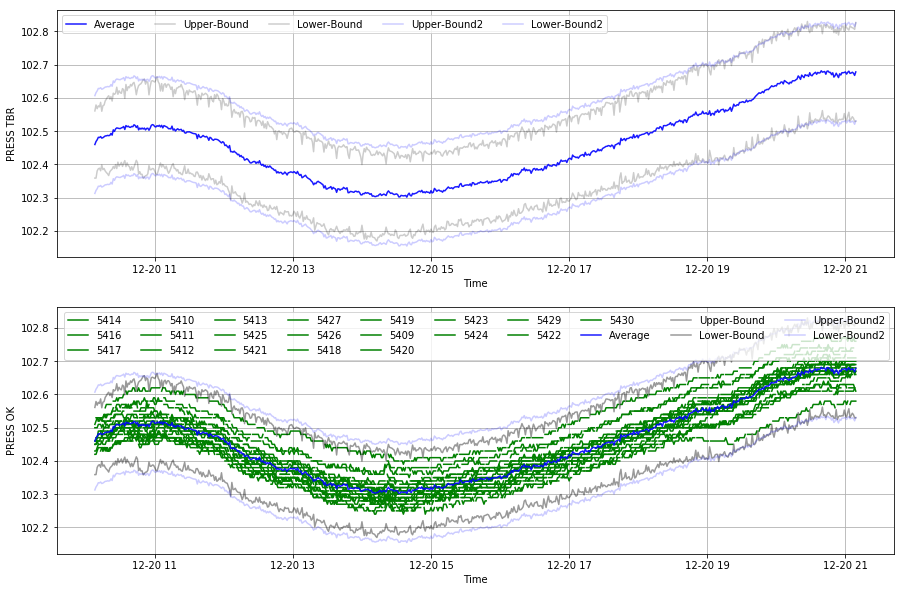

In [16]:
import numpy as np
import matplotlib.pyplot as plot

dispersion_test = 'DISPERSION'

list_channels = list()

# Get list of devices
list_devices = list(readings[dispersion_test]['devices'].keys())

# Init list of common channels
list_channels = readings[dispersion_test]['devices'][list_devices[0]]['data'].columns
min_date = pd.to_datetime('2000-01-01 00:00:00')
max_date = pd.to_datetime('2100-01-01 00:00:00')

min_date = min_date.tz_localize('UTC').tz_convert('Europe/Madrid')
max_date = max_date.tz_localize('UTC').tz_convert('Europe/Madrid')

# Extract list of common channels
for device in readings[dispersion_test]['devices']:
    list_channels = list(set(list_channels) & set(readings[dispersion_test]['devices'][device]['data'].columns))
    min_date = max(readings[dispersion_test]['devices'][device]['data'].index[0], min_date)
    max_date = min(readings[dispersion_test]['devices'][device]['data'].index[-1], max_date)

print 'Min - Max Date'
print min_date, max_date
if 'BATT' in list_channels: list_channels.remove('BATT')
if 'LIGHT' in list_channels: list_channels.remove('LIGHT')

print(list_channels)

# Trim dataset to min and max dates (normally these tests are carried out with _minutes_ of differences)
for device in list_devices:
    dataframe_cut = readings[dispersion_test]['devices'][device]['data']
    dataframe_cut = dataframe_cut[dataframe_cut.index > min_date]
    dataframe_cut = dataframe_cut[dataframe_cut.index < max_date]
    
dispersion_df = pd.DataFrame()

for channel in list_channels:
    list_columns = list()
    fig, (ax1, ax2) = plot.subplots(nrows = 2, figsize= (15,10))
    for device in list_devices:
        # Important to resample and bfill for unmatching measures
        dispersion_df[channel + '-' + device] = readings[dispersion_test]['devices'][device]['data'][channel].resample('1Min').bfill()
        list_columns.append(channel + '-' + device)

    # Calculate Metrics
    dispersion_df[channel + '_AVG'] = dispersion_df.loc[:,list_columns].mean(skipna=True, axis = 1)
    dispersion_df[channel + '_STD'] = dispersion_df.loc[:,list_columns].std(skipna=True, axis = 1)
    
    dispersion_global = 0
    limit_confidence_sigma = 0
    for item in dispersion_history:
        if channel == item[0]:
            dispersion_global = item[1]
            limit_confidence_sigma = item[2]
    
    dispersion_df[channel + '_MAX'] = dispersion_df.loc[:,list_columns].max(skipna=True, axis = 1)
    dispersion_df[channel + '_MIN'] = dispersion_df.loc[:,list_columns].min(skipna=True, axis = 1)
    
    upper_bound = dispersion_df[channel + '_AVG'] + limit_confidence_sigma*dispersion_df[channel + '_STD']
    lower_bound = dispersion_df[channel + '_AVG'] - limit_confidence_sigma*dispersion_df[channel + '_STD']
    
    upper_bound2 = dispersion_df[channel + '_AVG'] + limit_confidence_sigma*dispersion_global
    lower_bound2 = dispersion_df[channel + '_AVG'] - limit_confidence_sigma*dispersion_global
        
    for device in list_devices:
        if any(dispersion_df[channel + '-' + device] > upper_bound2) or any(dispersion_df[channel + '-' + device] < lower_bound2):
            alpha = 0.3
            color = 'r'
            ax1.plot(dispersion_df.index, dispersion_df[channel + '-' + device], color = color, label = device, alpha = alpha)

        else:
            alpha = 1
            color = 'g'
            ax2.plot(dispersion_df.index, dispersion_df[channel + '-' + device], color = color, label = device, alpha = alpha)

    ax1.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.9)
    ax1.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound', alpha = 0.2)
    ax1.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound', alpha = 0.2)
    
    ax1.plot(dispersion_df.index, upper_bound2, 'b', label = 'Upper-Bound2', alpha = 0.2)
    ax1.plot(dispersion_df.index, lower_bound2, 'b',label = 'Lower-Bound2', alpha = 0.2)
    ax1.legend(loc='best', ncol = 10)
    ax1.grid(True)
    ax1.set_ylabel(channel + ' TBR')
    ax1.set_xlabel('Time')
    
    ax2.plot(dispersion_df.index, dispersion_df[channel + '_AVG'],'b', label = 'Average', alpha = 0.9)
    ax2.plot(dispersion_df.index, upper_bound, 'k', label = 'Upper-Bound', alpha = 0.4)
    ax2.plot(dispersion_df.index, lower_bound, 'k',label = 'Lower-Bound', alpha = 0.4)

    ax2.plot(dispersion_df.index, upper_bound2, 'b', label = 'Upper-Bound2', alpha = 0.2)
    ax2.plot(dispersion_df.index, lower_bound2, 'b',label = 'Lower-Bound2', alpha = 0.2)
    ax2.legend(loc='best', ncol = 10)
    ax2.grid(True)
    ax2.set_ylabel(channel + ' OK')
    ax2.set_xlabel('Time')
    
plot.show()